In [52]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
from numba import njit, prange

from matplotlib import pyplot as plt

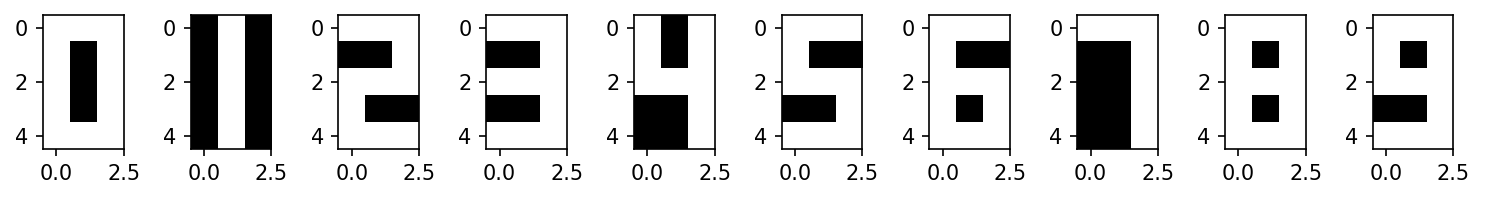

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_figwidth(10)
fig.set_dpi(150)

nums_mtrx =  np.loadtxt(Path('.', 'numbers.txt'))

for n, ax in zip(nums_mtrx, axes.ravel()):
    ax.imshow(n.reshape(5, 3), cmap='gray')

plt.tight_layout()
plt.show()

In [54]:
cells_columns = [f'c{n}' for n in range(15)]
classes = ['zero','one','two','three','four','five','six','seven','eight','nine']

df = pd.DataFrame(columns=cells_columns+['class'])

for i in range(10):
    new_row = dict(zip(cells_columns, nums_mtrx[i]))
    new_row['class'] = classes[i]
    
    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = nums_mtrx[i] + np.random.uniform(0, 0.1, 15)
        
        new_row = dict(zip(cells_columns, noised_num))
        new_row['class'] = classes[i]
        
        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

In [55]:
test_frac = 0.7

p = np.arange(10)

test_size = int(p.size*test_frac)
train_size = int(p.size*(1-test_frac))

idx_test = np.ravel([(p[0 : test_size] + i*10) for i in range(10)])
idx_train = np.ravel([(p[test_size : p.size] + i*10) for i in range(10)])

features_columns = cells_columns
label_columns = [f"{name}_label" for name in classes]

xTest = np.array(df.iloc[idx_test][features_columns])
yTest = np.array(df.iloc[idx_test][label_columns])

xTrain = np.array(df.iloc[idx_train][features_columns])
yTrain = np.array(df.iloc[idx_train][label_columns])

In [56]:
@njit(fastmath=True)
def F(x: np.ndarray) -> np.ndarray:
    # return x
    # return np.maximum(np.zeros(x.shape), x)
    # return np.clip(x,-1, 1)
    return np.tanh(x)


@njit(fastmath=True)
def dF(x: np.ndarray) -> np.ndarray:
    # return np.ones(x.shape)
    # return 1 * (x > 0)
    # return np.array([0 if xi <= -1 or xi >= 1 else 1 for xi in x])
    return 1-np.square(np.tanh(x))


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1/(1+np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1/(1+np.exp(-x))
    return y*(1-y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y/np.sum(y)

In [57]:
@njit(fastmath=True)
def grads(xBatch: np.ndarray, w: np.ndarray, Bh:np.ndarray, b:np.ndarray) -> tuple[np.ndarray]:
    dw = np.zeros(w.shape)
    dBh = np.zeros(Bh.shape)
    db = np.zeros(b.shape)
    
    for i in prange(xBatch.shape[0]):
        u = xBatch[i] @ w + Bh
        y = F(u) @ w.T + b

        dLdy = 2/(w.shape[0]* w.shape[1]) * (y-xBatch[i])
        
        dw += (dLdy @ w) * dF(u) * np.atleast_2d(xBatch[i]).T
        dBh += (dLdy @ w) * dF(u)
        db += dLdy
    
    return (dw, dBh, db)


class RestrictedBoltzmannMachine:
    def __init__(self, nIn: int, nHidden: int) -> None:
        self.nIn = nIn
        self.nHidden = nHidden
        
        self.w: np.ndarray = np.random.uniform(-1, 1, (nIn, nHidden))
        
        self.Bh: np.ndarray = np.zeros(nHidden)
        self.b: np.ndarray = np.zeros(nIn)


    def predict(self, x:np.ndarray) -> np.ndarray:
        # return (x @ self.w + self.Bh) @ self.w.T + self.b
        return F(x @ self.w + self.Bh) @ self.w.T + self.b


    def train(self, xTrain: np.ndarray, lr, batch_size, max_iter) -> None:
        n = xTrain.shape[0]

        for k in range(max_iter):
            idxs = np.random.choice(a=np.arange(n), size=batch_size, replace=False)
            
            dw, dBh, db = grads(xTrain[idxs], self.w, self.Bh, self.b)
            
            self.w -= lr*dw
            self.Bh -= lr*dBh
            self.b -= lr*db
        
    
    def loss(self, x: np.ndarray) -> float:
        xPred = np.array([self.predict(xi) for xi in x])
        d = 1/self.nIn * np.linalg.norm(x-xPred, axis=1)
        return 1/x.shape[0] * np.sum(d)

In [81]:
nIn = 15
nHidden = 30

lr = 1e-2
batch_size = 16
max_iter = 30000

model = RestrictedBoltzmannMachine(nIn, nHidden)

print('untrained loss: {0:.6f}'.format(model.loss(xTest)))

model.train(xTrain, lr, batch_size, max_iter)

print('trained loss: {0:.6f}'.format(model.loss(xTest)))

untrained loss: 0.804132
trained loss: 0.029663


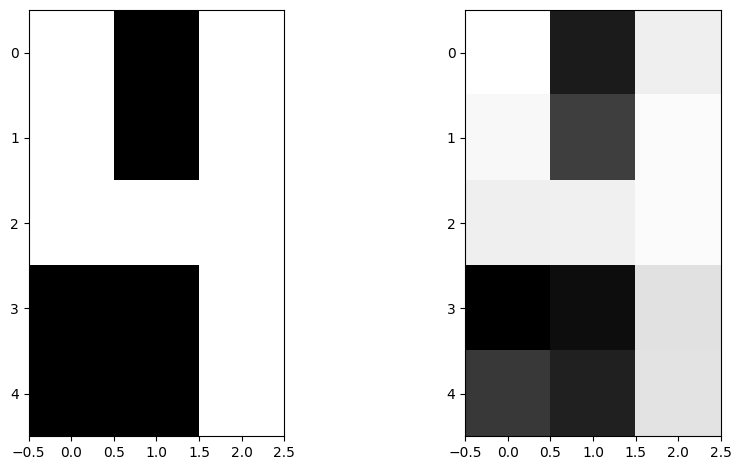

In [89]:
i = random.randint(0,9)

x = nums_mtrx[i]
xPred = model.predict(x)

fig, axes = plt.subplots(nrows=1, ncols=2)

fig.set_dpi(100)
fig.set_figwidth(10)

axes[0].imshow(x.reshape((5,3)), cmap='gray')
axes[1].imshow(xPred.reshape((5,3)), cmap='gray')

plt.tight_layout()
plt.show()